 ..In this notebook, I apply One-Class SVM (Support Vector Machine) for anomaly detection on the same dataset previously used with a supervised SVM. Unlike the supervised case, One-Class SVM is treated here as a completely unsupervised method, where the model learns the profile of the majority class (normal transactions) and then flags deviations as potential anomalies (fraud).

The model achieved a recall of ~85% on the fraud class, which is especially important in fraud detection, since catching the majority of fraudulent cases is more critical than overall accuracy.

In [21]:
#Importing necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
 from google.colab import files

uploaded = files.upload()

In [22]:
df = pd.read_csv("creditcard.csv")



In [23]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:

X = df.drop(columns=["Class"])
y = df["Class"]

In [ ]:
# Splitting  into normal and fraud sets
X_normal = X[y == 0]
X_fraud = X[y == 1]

In [ ]:
 df.shape

In [ ]:

print("Normal samples:", len(X_normal))
print("Fraud samples:", len(X_fraud))

In [ ]:
# Training set only Normal  transactions .
#Once class svm should learn rest when it sees anomaly it will flag in inference

In [ ]:
X_train = X_normal.sample(n=20000, random_state=42)  #taking 20k from a pool of 200k

In [ ]:
# Test set is mix of normals and frauds
X_test_normal = X_normal.drop(X_train.index).sample(n=5000, random_state=42)  # taking 5 k
X_test_fraud = X_fraud

In [ ]:
X_test_oc = pd.concat([X_test_normal, X_test_fraud], axis=0)
y_test_oc = np.hstack([np.ones(len(X_test_normal)), -np.ones(len(X_test_fraud))])  #(1,-1) and horizontal stacking


# Convention in once class svm like Isolation forest  +1 = normal, -1 = fraud

In [ ]:
# Creating the one class Svm pipeline

oc_svm = Pipeline([
    ("scaler", StandardScaler()),   # Scaling as once class is class sensitve and Time and amount is not scaled rest df is Pca scaled
    ("oc", OneClassSVM(kernel="rbf", gamma="scale", nu=0.01))  # choosing radial bias function  kernel ,
])   #nu controls slackness of decision boundary how much outlier we want to detect

# C paremeter is replaced by nu in Once class SVM


#fraction of training data expected to be outliers tuning  between 0.01–0.05

In One class svm its common  to use RBF as we are not intrested to find a Hyperplane but a decision boundary that separates pt from origin ,Its like finding a enclosing boundary thats non linear And anything outside boundary is outlier,Origin acts a pseudo second class

In [ ]:
#fitting it

oc_svm.fit(X_train)

In [ ]:
#prediction

y_pred_oc = oc_svm.predict(X_test_oc)

In [26]:
#confusion matrix

print("\nConfusion Matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test_oc, y_pred_oc, labels=[1, -1])
print(cm)



Confusion Matrix (rows=true, cols=pred):
[[4867  133]
 [  74  418]]


In [25]:
print("\nClassification Report (fraud=-1 as positive class):")
print(classification_report(y_test_oc, y_pred_oc, digits=4))



Classification Report (fraud=-1 as positive class):
              precision    recall  f1-score   support

        -1.0     0.7586    0.8496    0.8015       492
         1.0     0.9850    0.9734    0.9792      5000

    accuracy                         0.9623      5492
   macro avg     0.8718    0.9115    0.8904      5492
weighted avg     0.9647    0.9623    0.9633      5492



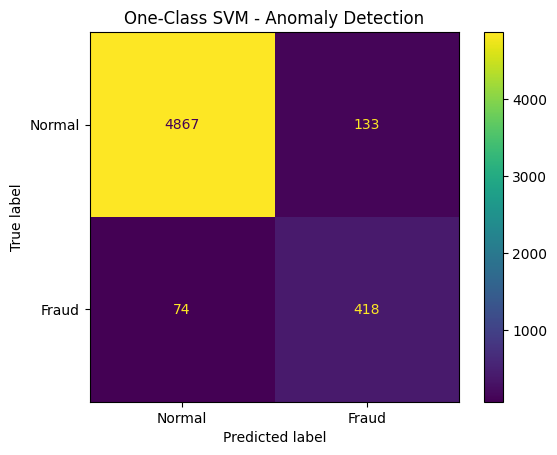

In [24]:
# Visualizing  confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Fraud"])
disp.plot()
plt.title("One-Class SVM - Anomaly Detection")
plt.show()